## A/B Testing in E-commerce

Author: CHENG CHEN <br/>
LinkedIn: https://www.linkedin.com/in/chengchen-jimmy<br/>
Date: 06/30/2018<br/>

This is a A/B testing tutorial. I will go through a basic A/B testing problem in the e-commerce field. The data comes from BitTiger. Please indicate the source if sharing. 

If you would like to give any suggestion or correct any field, I could be reached at cheng.chen.2017@marshall.usc.edu. It will be very helpful! Thanks beforehand!

### Business Background & Questions

This data shows user's activities on a online sales website.  
 
An experiment was launched on day 4 with a goal to increase users' click through rate (clicks/views) and total revenue. 
 
Note: first 3 days no experiment, 4th-14th days experiment running 
 
Analyze the data and write a report to answer the following questions: 

1. Is the experiment correct? Please note any problems in your report. 

2. Did the test version help increase CTR and total revenue? Help the team make the right decisions. 

3. There might be learning effect for users to get used to the change. Help the team understand this.

### 1. Import the Dataset

In [1]:
# from pip._internal import main
# main(['install', 'pandasql'])

In [42]:
## import libraries
import os
import pandas as pd
import pip
import pandasql as ps
import numpy as np
import datetime
import scipy
import random

In [43]:
# change work directory
os.chdir('D:\\AB Testing')
# read in the dataset
dat = pd.read_csv('abtest_example_ctr.csv')
# dat.head()
dat.head()

,userid,country,groups,deviceid,device,sellerid,itemid,date,views,clicks,revenue
0,3441.0,US,control,12745,Ios,306,1685,2017-05-09,5,1,0.00000
1,3048.0,GB,control,19244,Android,227,2257,2017-05-09,3,1,0.00000
2,6640.0,CA,treatment,17198,Other,220,2977,2017-05-10,8,2,114.09041
3,4326.0,US,control,5329,Ios,431,1471,2017-05-12,4,0,0.00000
4,6993.0,US,control,15955,Web,399,1812,2017-05-08,4,2,0.00000


### 2. Summary of Statistics

In [44]:
## Summary of statistics
print('Columns are: ', list(dat.columns))
print()
print('Data contains \n', dat.shape[0], ' rows, and ', dat.shape[1], ' columns')
print()
print('Data contains \n', 
      np.unique(dat['country']).size, ' countries \n',
      np.unique(dat['userid']).size, ' userids \n',
      np.unique(dat['deviceid']).size, 'deviceids \n',
      np.unique(dat['sellerid']).size, 'sellerids \n',
      np.unique(dat['itemid']).size, 'itemids \n',
      'Date started from ', min(dat['date']), ' to ', max(dat['date']), ' in total lasts ', \
      (max(pd.to_datetime(dat['date'])) - min(pd.to_datetime(dat['date']))).days + 1, ' days.')

Columns are:  ['userid', 'country', 'groups', 'deviceid', 'device', 'sellerid', 'itemid', 'date', 'views', 'clicks', 'revenue']

Data contains 
 22960  rows, and  11  columns

Data contains 
 4  countries 
 7853  userids 
 7709 deviceids 
 401 sellerids 
 1968 itemids 
 Date started from  2017-05-08  to  2017-05-21  in total lasts  14  days.


In [45]:
# Describe the dataset
np.round(dat.describe(include = 'all'))

,userid,country,groups,deviceid,device,sellerid,itemid,date,views,clicks,revenue
count,22685.0,22960,22960,22960.0,22960,22960.0,22960.0,22960,22960.0,22960.0,22960.0
unique,NaN,4,2,NaN,4,NaN,NaN,14,NaN,NaN,NaN
top,NaN,US,treatment,NaN,Android,NaN,NaN,2017-05-16,NaN,NaN,NaN
freq,NaN,9182,11500,NaN,7003,NaN,NaN,1721,NaN,NaN,NaN
mean,5485.0,NaN,NaN,12566.0,NaN,302.0,1998.0,NaN,6.0,1.0,12.0
std,2584.0,NaN,NaN,4367.0,NaN,116.0,574.0,NaN,3.0,1.0,38.0
min,1000.0,NaN,NaN,5000.0,NaN,100.0,1000.0,NaN,0.0,0.0,0.0
25%,3256.0,NaN,NaN,8758.0,NaN,203.0,1508.0,NaN,4.0,0.0,0.0
50%,5450.0,NaN,NaN,12538.0,NaN,304.0,1994.0,NaN,6.0,1.0,0.0
75%,7717.0,NaN,NaN,16409.0,NaN,402.0,2497.0,NaN,7.0,2.0,0.0


### 3. Data Sanity Check

**Data Exploration**

* __Check for % of test/control units. Is the % matching DOE?__
    * If not match, need to figure out what's the cause? - inbalanced assignment needs to meet expectation;
* __Check for miexed assignment__
    * It's hard to solve. If # of mixed samples is small, OK to remove. If big, need to figure out what's the cause; 
    * What's the problem of throwing away mixed samples?
        * Because mixed assigned user might be highly active users; 
        * If we remove them all, we potentially fail to understand the active users in our product;
        * A good workaround is, if the user is in both groups, we throw all the records of him to test group;
        * It potentially dilutes the test group and weakenes the test effect. -> a conservative method. 
* __Sanity Check__
    * Are test/control similar in other factors other than treatment?

As this experiment focuses on users' click through rate and total revenue, userid will be the assignment unit of this experiment.

In [46]:
# Check missing values of userid
print('# of misssing userids: ', dat['userid'].isnull().sum())
print('Prop of # missing userid records: ', dat['userid'].isnull().sum()/dat.shape[0]) # less than 1.2%

# of misssing userids:  275
Prop of # missing userid records:  0.011977351916376307


In [47]:
# Check for mixed assignment
# Mixed assignment: same users has been assigned to both control and treatment  

# Here I will be using sql ... for fun
#sql_code = """
#SELECT DISTINCT userid FROM dat WHERE groups = 'treatment'
#INTERSECT
#SELECT DISTINCT userid FROM dat WHERE groups = 'control';
#"""
#pysqldf = lambda q: ps.sqldf(q, globals())
#mixAssign = ps.sqldf(sql_code)

mixAssign = set(dat.loc[dat.groups == 'control', 'userid']) & set(dat.loc[dat.groups == 'treatment', 'userid'])
len(mixAssign)

43

In [48]:
# Check for multiple-user per device
mulUser = dat.groupby('deviceid')['userid'].nunique() #  number of unique elements in the object. exclude NA by default
mulUser = set(mulUser[mulUser>1].index)
len(mulUser)

136

In [49]:
# Check for multiple-device per user
mulDev = dat.groupby('userid')['deviceid'].nunique()
mulDev = set(mulDev[mulDev>1].index)
len(mulDev)

175

In [50]:
# Check if NA/mixed/multiple-device/multiple-user is random
# Create dummy, if any problem 1, else 0.
dat['Deficit'] = dat.apply(lambda x: int((x['userid'] in mixAssign|mulDev) | np.isnan(x['userid']) | (x['deviceid'] in mulUser)), axis = 1)
dat['Deficit'].sum()

1823

For simplicity, we run a simple logistic regression model as there are not many covariates. And check the p-value of each variables to see if the missing is associate with specific country/groups/device/date/views/clicks/revenue.

But in the first place, to use sklearn, we need to 'dummy' those variables


In [51]:
# Create dummy variables
datCheck = dat.copy()
datCheck = pd.get_dummies(datCheck[['country', 'groups', 'device', 'date', 'views', 'clicks', 'revenue', 'Deficit']])
datCheck.drop(columns = ['country_CA', 'groups_control', 'date_2017-05-08', 'device_Android'], inplace = True)
datCheck.head()

,views,clicks,revenue,Deficit,country_CN,country_GB,country_US,groups_treatment,device_Ios,device_Other,...,date_2017-05-12,date_2017-05-13,date_2017-05-14,date_2017-05-15,date_2017-05-16,date_2017-05-17,date_2017-05-18,date_2017-05-19,date_2017-05-20,date_2017-05-21
0,5,1,0.00000,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,1,0.00000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2,114.09041,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0.00000,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,4,2,0.00000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Run a simple logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, C=1e6) # lower C means higher penalty, use convention in SVM
lr.fit(datCheck.loc[:,datCheck.columns!='Deficit'], datCheck['Deficit'])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
# Check the attributes
print('intercept: ', lr.intercept_)
dict(zip(datCheck.columns[datCheck.columns!='Deficit'], lr.coef_[0]))

# Note:
# sklearn doesn't provide built-in P-value and other statistical calculation 

intercept:  [-2.44275683]


{'views': 0.003676205223950213,
 'clicks': -0.032457761797823496,
 'revenue': 0.0002996713985630129,
 'country_CN': -0.12864775250729915,
 'country_GB': -0.15981963077922479,
 'country_US': -0.09787344286589661,
 'groups_treatment': -0.028145905795962302,
 'device_Ios': 0.13190803322761677,
 'device_Other': 0.18063270969294815,
 'device_Web': 0.11274798162673037,
 'date_2017-05-09': -0.09359675762579389,
 'date_2017-05-10': -0.027372523582008923,
 'date_2017-05-11': 0.028565325749638566,
 'date_2017-05-12': 0.09078756077920669,
 'date_2017-05-13': 0.0347781267873893,
 'date_2017-05-14': 0.2117121449867692,
 'date_2017-05-15': -0.0975895380608316,
 'date_2017-05-16': -0.006356662512770055,
 'date_2017-05-17': 0.03814663794821731,
 'date_2017-05-18': -0.024250236173639826,
 'date_2017-05-19': 0.049119346515590384,
 'date_2017-05-20': 0.03767493806071268,
 'date_2017-05-21': -0.03397509740435897}

In [54]:
# Alternative logistic regression packages/api
# use statsmodels.api to get the P-value
import statsmodels.api as sm
datCheck['intercept'] = 1 # Note, if we don't have the intercept, statsmodels will by default has not intercept
model = sm.Logit(datCheck['Deficit'], datCheck.loc[:,datCheck.columns!='Deficit'])
result = model.fit()
result.summary()
# if we have P-value, we should be able to know that country_GB and device_Other are significant in the logistic regression.
# we can dive deep to see what happens there.

Optimization terminated successfully.
         Current function value: 0.276770
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Deficit   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22936
Method:                           MLE   Df Model:                           23
Date:                Wed, 08 Aug 2018   Pseudo R-squ.:                0.001908
Time:                        18:19:17   Log-Likelihood:                -6354.6
converged:                       True   LL-Null:                       -6366.8
                                        LLR p-value:                    0.3874
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
views                0.0037      0.011      0.326      0.745      -0.019       0.026
clicks              -0.0325      0.027     -1.225      0.221      -0.084       0.019
revenue              0.0003      0.001      0.456      0.648      -0.001       0.002
country_CN          -0.1284      0.076     -1.679      0.093      -0.278       0.021
country_GB          -0.1596      0.077     -2.079      0.038      -0.310      -0.009
country_US          -0.0977      0.065     -1.497      0.134      -0.226       0.030
groups_treatment    -0.0280      0.049     -0.574      0.566      -0.124       0.068
device_Ios           0.1320      0.071      1.859      0.063      -0.007       0.271
device_Other         0.1807      0.070      2.599      0.009       0.044       0.317
device_Web           0.1129      0.065      1.748      0.080      -0.014       0.239
date_2017-05-09     -0.0935      0.134     -0.696      0.487      -0.357       0.170
date_2017-05-10     -0.0273      0.133     -0.206      0.837      -0.288       0.233
date_2017-05-11      0.0286      0.131      0.218      0.828      -0.229       0.286
date_2017-05-12      0.0908      0.130      0.701      0.483      -0.163       0.345
date_2017-05-13      0.0348      0.130      0.267      0.790      -0.221       0.290
date_2017-05-14      0.2119      0.127      1.662      0.096      -0.038       0.462
date_2017-05-15     -0.0975      0.134     -0.729      0.466      -0.360       0.165
date_2017-05-16     -0.0064      0.131     -0.049      0.961      -0.263       0.250
date_2017-05-17      0.0381      0.131      0.292      0.770      -0.218       0.294
date_2017-05-18     -0.0242      0.133     -0.182      0.856      -0.286       0.237
date_2017-05-19      0.0492      0.131      0.375      0.708      -0.208       0.306
date_2017-05-20      0.0377      0.131      0.288      0.774      -0.219       0.295
date_2017-05-21     -0.0339      0.134     -0.253      0.800      -0.297       0.229
intercept           -2.4432      0.130    -18.832      0.000      -2.697      -2.189
====================================================================================
"""

*Very Important*: we can see the coefficient lines up with the previous one.

Let's compare three ways of logistic regression calculation:
* R: no need to create dummy and has statistics. use code: "m = glm(y ~ x1 + x2 + ... + x3, data, family = 'binomial') \n summary(m)"
* sklearn: needs to create dummy variables; no p-value & other statistics.
* statsmodels.api: needs to create dummy variables and need to specify 'intercept', otherwise intercept is not there by default.

In [55]:
# Example: Dive deep into device_other (similar analysis could be applied on Country_GB)
# since the device_other has a significant effect, let dive deep into this
dat['nullUser'] = dat['userid'].isnull()*1
dat['mixAssign'] = dat['userid'].apply(lambda x: int(x in mixAssign))
dat['mulUser'] = dat['deviceid'].apply(lambda x: int(x in mulUser))
dat['mulDev'] = dat['userid'].apply(lambda x: int(x in mulDev))
# sum(np.sum(dat[['nullUser','mixAssign','mulUser','mulDev']],axis=1)>=1) # 1823 Checked!
print(dat.groupby('device')['nullUser'].mean())
print(dat.groupby('device')['mixAssign'].mean())
print(dat.groupby('device')['mulUser'].mean()) # higher multiple user percent - is it expected? bug? talk to engineers.
print(dat.groupby('device')['mulDev'].mean())

device
Android    0.013708
Ios        0.008946
Other      0.009752
Web        0.013820
Name: nullUser, dtype: float64
device
Android    0.004998
Ios        0.004582
Other      0.007632
Web        0.008863
Name: mixAssign, dtype: float64
device
Android    0.029702
Ios        0.037530
Other      0.043884
Web        0.029743
Name: mulUser, dtype: float64
device
Android    0.038983
Ios        0.050185
Other      0.045792
Web        0.044765
Name: mulDev, dtype: float64


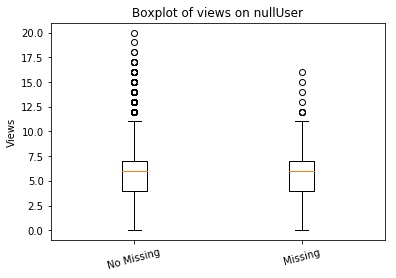

In [56]:
# Also, we can do some viz of key metrics:
# help define whether problematics records are caused by some specific problems (channel, engineering...)
# key metrics: views, clicks, click-through-rate
import matplotlib.pyplot as plt
plt.boxplot([dat['views'][dat['nullUser']==0], dat['views'][dat['nullUser']==1]])
plt.xticks([1,2],('No Missing','Missing'), rotation=15)
plt.ylabel('Views')
plt.title('Boxplot of views on nullUser')
plt.show()
# 'nullUser' could be replaced by ['mixAssign', 'mulUser', 'mulDev']
# 'views' could be replaced by 'clicks'

In [57]:
# In this case, we throw away all problematic assignments for simplicity.
dat = dat.loc[dat['Deficit']!=1,:]
dat.shape

(21137, 16)

__For simplicity, we throw away all the problematic assignments in this case. In reality, do not do this by default. Need to go through details within groups and check carefully.__

In [58]:
# Sanity check on filtered data 
# Check whether metrics are comparable before experiment (if there has difference betwen control and treatment)
# Day 1 - 3 (before experiment)
dat['date'] = pd.to_datetime(dat['date'])
experiment_date = min(dat['date'])+datetime.timedelta(days=3)
dat_bef = dat.loc[dat['date']<experiment_date,:]
dat_bef.shape

(4487, 16)

In [59]:
# aggregated CTR between treament/control before experiment start
x1 = dat_bef.loc[dat_bef['groups']=='control', 'clicks'].sum()
x2 = dat_bef.loc[dat_bef['groups']=='treatment', 'clicks'].sum()
n1 = dat_bef.loc[dat_bef['groups']=='control', 'views'].sum()
n2 = dat_bef.loc[dat_bef['groups']=='treatment', 'views'].sum()
print(x1, x2, n1, n2)
# 2-sample test for equality of proportions with continuity correction
# (x1, x2) out of (n1, n2), two-sides hypothesis test
# Attention on the API:
# the first argument is 'observed' : array_like, contingency table
# It takes in the observed values: np.array([[success1, success2], [failure1, failure2]]) 
scipy.stats.chi2_contingency(np.array([[x1,x2], [n1-x1, n2-x2]]), correction = True)
#(0.00275424098602548, -> chi-squared
# 0.958145543396146, -> P value -> the change is not significant on the global scale, we can dive deep to check!
# 1, -> Degrees of freedom
# array([[2361.1150762, 2364.8849238], -> expected 
#        [9538.8849238, 9554.1150762]]))

2359 2367 11900 11919


(0.00275424098602548,
 0.958145543396146,
 1,
 array([[2361.1150762, 2364.8849238],
        [9538.8849238, 9554.1150762]]))

__We can conclude with 95% confidence that CTR is comparable before the experiment.__

__The peer function in R is prop.test__ <br>
Below are three same chi-square: <br>
__x1__: # of success in group 1 <br>
__x2__: # of success in group 2 <br>
__n1__: # of experiments in group 1 <br>
__n2__: # of experiments in group 2 <br>
__(1) R__: prop.test(x=c(x1, x2), n=c(n1, n2), alternative='two.sided') <br>
__(2) R__: prop.test(matrix(c(n1-x1,n2-x2,x1,x2), ncol=2), alternative = 'two.sided') <br>
__(3) Python__: scipy.stats.chi2_contingency(np.array([[x1,x2], [n1-x1, n2-x2]]), correction = True) <br>


In [60]:
# compare other fields -> for example, device
dat_bef.groupby(['groups', 'device'])['device'].count().groupby(level=0).apply(lambda x: x / x.sum()) # no dramatic diff

groups     device 
control    Android    0.308344
           Ios        0.203927
           Other      0.201696
           Web        0.286033
treatment  Android    0.317453
           Ios        0.197685
           Other      0.206589
           Web        0.278272
Name: device, dtype: float64

In [61]:
# compare other fields -> for example, country
dat_bef.groupby(['groups', 'country'])['country'].count().groupby(level=0).apply(lambda x: x / x.sum()) # no dramatic diff

groups     country
control    CA         0.199018
           CN         0.192771
           GB         0.217314
           US         0.390897
treatment  CA         0.207035
           CN         0.202137
           GB         0.197685
           US         0.393143
Name: country, dtype: float64

In [62]:
# Day 4 + (after experiemnt)
dat_aft = dat.loc[dat['date']>=experiment_date,:]
dat_aft.shape 

(16650, 16)

### 4. Hypothesis Testing

In [63]:
# Hypothesis Testing
# aggregated CTR between treament/control after experiment start
x1 = dat_aft.loc[dat_aft['groups']=='control', 'clicks'].sum()
x2 = dat_aft.loc[dat_aft['groups']=='treatment', 'clicks'].sum()
n1 = dat_aft.loc[dat_aft['groups']=='control', 'views'].sum()
n2 = dat_aft.loc[dat_aft['groups']=='treatment', 'views'].sum()
print(x1, x2, n1, n2)
# 2-sample test for equality of proportions with continuity correction
# (x1, x2) out of (n1, n2), two-sides hypothesis test
# Attention on the API:
# the first argument is 'observed' : array_like, contingency table
# It takes in the observed values: np.array([[success1, success2], [failure1, failure2]]) 
scipy.stats.chi2_contingency(np.array([[x1,x2], [n1-x1,n2-x2]]), correction = True)
#(3.066794164712745, -> chi-squared
# 0.07990690688697542, -> P value -> the change is not significant on the global scale, we can dive deep to check!
# 1, -> Degrees of freedom
# array([[10044.36335262, 10097.63664738], -> expected 
#        [39165.63664738, 39373.36335262]]))

9933 10209 49210 49471


(3.066794164712745,
 0.07990690688697542,
 1,
 array([[10044.36335262, 10097.63664738],
        [39165.63664738, 39373.36335262]]))

In [64]:
# compare other fields -> for example, device
dat_aft.groupby(['groups', 'device'])['device'].count().groupby(level=0).apply(lambda x: x / x.sum()) # no dramatic diff

groups     device 
control    Android    0.295359
           Ios        0.206751
           Other      0.202532
           Web        0.295359
treatment  Android    0.316218
           Ios        0.190425
           Other      0.205386
           Web        0.287971
Name: device, dtype: float64

In [65]:
# compare other fields -> for example, country
dat_aft.groupby(['groups', 'country'])['country'].count().groupby(level=0).apply(lambda x: x / x.sum()) # no dramatic diff

groups     country
control    CA         0.193972
           CN         0.203134
           GB         0.199638
           US         0.403255
treatment  CA         0.197965
           CN         0.197846
           GB         0.203232
           US         0.400958
Name: country, dtype: float64

In [66]:
# dive deep by group level, no longer on global scale
def test_by_subgroup(data, col, val):
    """
    type data: pandas dataframe
    type col: string
    type val: string or number
    rtype: tuple of values
    """
    data_use = data.loc[data[col]==val, :]
    x1 = data_use.loc[data_use['groups']=='control', 'clicks'].sum()
    x2 = data_use.loc[data_use['groups']=='treatment', 'clicks'].sum()
    n1 = data_use.loc[data_use['groups']=='control', 'views'].sum()
    n2 = data_use.loc[data_use['groups']=='treatment', 'views'].sum()
    return(scipy.stats.chi2_contingency(np.array([[x1,x2], [n1-x1,n2-x2]]), correction = True))

In [67]:
# iterate through values in country and device
# country
test_by_country = list()
for i in dat_aft['country'].unique():
    test_by_country.append([i]+list(test_by_subgroup(dat_aft, 'country', i))[0:3])
# convert list to pandas for viz
test_by_country = pd.DataFrame(test_by_country, columns = ['country', 'chi2 test statistics', 'P-value', 'DF'])
test_by_country
# It seems that CA has a relatively significant difference

,country,chi2 test statistics,P-value,DF
0,US,0.930288,0.334788,1
1,CN,0.756994,0.384271,1
2,GB,2.250526,0.133569,1
3,CA,3.578450,0.058534,1


In [68]:
# device
test_by_device = list()
for i in dat_aft['device'].unique():
    test_by_device.append([i]+list(test_by_subgroup(dat_aft, 'device', i))[0:3])
# convert list to pandas for viz
test_by_device = pd.DataFrame(test_by_device, columns = ['device', 'chi2 test statistics', 'P-value', 'DF'])
test_by_device
# Ios is significant different! Discuss with Engineering team and Product Management team.
# Is this a engineering bug? Or is it really because of the difference across platforms?
# Dive deep!

,device,chi2 test statistics,P-value,DF
0,Ios,12.838918,0.000339,1
1,Other,0.385177,0.534846,1
2,Web,0.497695,0.480515,1
3,Android,0.732704,0.392008,1


### 5. Revenue

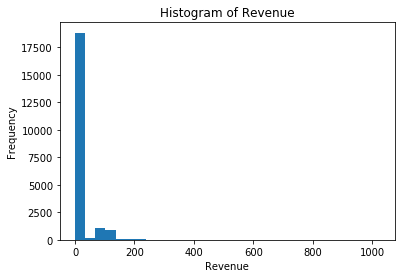

In [69]:
# Quick Histogram of Revenue 
plt.hist(dat['revenue'], bins = 30)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Revenue')
plt.show() # Highly right skewed

In [70]:
# Porportion of Revenue = 0
print(round(100*sum(dat.revenue==0)/dat.shape[0],2), '% of records contain 0 revenue.') # 89%

89.01 % of records contain 0 revenue.


The **Revenue** is usually highly skewed and a big proportion is actually **Revenue = 0**. <br>

**Solutions when data is highly skewed or statistics is hard to approximate with CLT?** <br>
For exammple:<br>
1. Metrics like revenue is highly skewed & have outliers; <br>
2. In risk and fraud, most transactions have no loss while some fraud transactions have very high loss; <br>

* Transformation (hard to interpret); <br>
* Winsorization / Capping <br>
* Bootstrap <br>

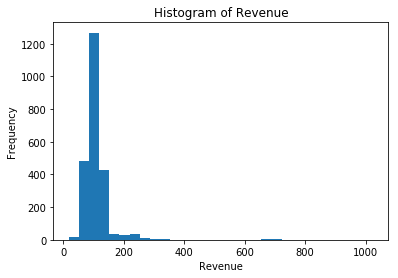

In [31]:
# Quick Histogram of None-Zero Revenue 
plt.hist(dat['revenue'][dat.revenue!=0], bins = 30)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Revenue')
plt.show() # Still highly right skewed

In [71]:
# winsorization, capping
bound = np.percentile(dat['revenue'][dat.revenue!=0], 99.9) # values over 99% Percentile, set to 99% Percentile
Revenue = dat['revenue'][dat.revenue!=0]
Revenue[Revenue>bound] = bound

In [72]:
# Method 1: use CLT for estimator, distribution of Mean Revenue
E_mean = np.mean(Revenue)
E_var = np.var(Revenue)/len(Revenue)
print(E_mean, E_var)

108.63033901551636 1.017984449852736


In [34]:
# Method 2: use bootstrap for estimator, distribution of Mean Revenue
# Bootstrap is a resampling method. 
# It can be used to estimate sampling distribution of any statistics, 
# commonly used in estimating CI & P-value & statistics with complex or no close-form estimator;
btsample = list()
for i in range(1000):
    btsample.append(np.mean([random.choice(list(Revenue)) for j in range(len(Revenue))]))
bt_mean = np.mean(btsample)
bt_var = np.var(btsample)
print(bt_mean, bt_var)

106.84922160717728 0.45583914980336954


In [35]:
# Method 2+: use bootstrap for estimator, distribution of 90% Percentile Revenue
btsample = list()
for i in range(1000):
    btsample.append(np.percentile([random.choice(list(Revenue)) for j in range(len(Revenue))], 90))
bt_90pt_mean = np.mean(btsample)
bt_90pt_var = np.var(btsample)
print(bt_90pt_mean, bt_90pt_var)

133.25440073292134 1.7884030812161904


### 6. Result Analysis

In this part we will be doing: <br>
* __Regression Adjustment__ <br>
    Y_post = beta_pre * Y_pre + beta_t * Treatment_Group <br>
    <br>
* __Diff-in-Diff Comparisons__<br>
    (Y_post/t - Y_pre/t) - (Y_post/c - Y_pre/c) 

We had the assumption that the A/B groups have no difference before experiment. What if it does exist difference? __Use detrended (bias removed) numbers to put into test models;__

In [73]:
# Let's set the bound to be 99.9% percentile
# we use 99.9 percentile as bound in revenue > 0
bound = np.percentile(dat['revenue'][dat.revenue!=0], 99.9)
dat_bef.loc[dat_bef.revenue>bound, 'revenue'] = bound
dat_aft.loc[dat_aft.revenue>bound, 'revenue'] = bound

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
# Regular t test
ctrl_revenue = dat_aft.loc[dat_aft.groups == 'control', 'revenue']
test_revenue = dat_aft.loc[dat_aft.groups == 'treatment', 'revenue']
scipy.stats.ttest_ind(np.array(ctrl_revenue), np.array(test_revenue), equal_var = False)
# result is the mean revenue (including 0) doesn't change significantly after the experiment, 
# when only looking at dat_aft (not considering pre-bias)

Ttest_indResult(statistic=1.374603111674076, pvalue=0.1692730714744911)

In [75]:
# There might be some bias prior to experiment start
# Assuming the change happens instantly, no learning effect, then it is fine to do same-weight ensemble
# 1. avg daily revenue of each user before experiment
daily_rev_pre = dat_bef.groupby(['userid', 'country', 'device', 'groups'])['revenue'].sum()/3
daily_rev_pre = daily_rev_pre.to_frame().reset_index().set_index('userid')
# 2. avg daily revenue of each user after experiment
daily_rev_post = dat_aft.groupby(['userid', 'country', 'device', 'groups'])['revenue'].sum()/11
daily_rev_post = daily_rev_post.to_frame().reset_index().set_index('userid')
# 3. daily revenue (index: userid, col1: rev_pre, col2: rev_post)
# left join here. Post on the left, depends on the interpretation;
# Personally, I think inner join make better sense here. 
daily_rev = pd.merge(daily_rev_post , daily_rev_pre, left_index=True, right_index=True, how='left')
daily_rev.loc[daily_rev.revenue_y.isnull() ,'revenue_y'] = 0 # fill in missing value

In [76]:
# Regression Adjustment pre diff
# create dummy for daily_rev
daily_rev = pd.get_dummies(daily_rev[['groups_x', 'country_x', 'device_x', 'revenue_x', 'revenue_y']], drop_first = True)
daily_rev['intercept'] = 1 # Note, if we don't have the intercept, statsmodels will by default has not intercept
daily_rev.head()

,revenue_x,revenue_y,groups_x_treatment,country_x_CN,country_x_GB,country_x_US,device_x_Ios,device_x_Other,device_x_Web,intercept
userid,,,,,,,,,,
1000.0,26.88051,0.0,0,0,0,1,0,0,0,1
1001.0,0.00000,0.0,1,0,0,0,0,1,0,1
1003.0,0.00000,0.0,0,0,0,0,0,1,0,1
1005.0,18.22475,0.0,1,0,0,1,0,0,0,1
1006.0,0.00000,0.0,1,0,0,0,1,0,0,1


In [77]:
# use linear regression, use groups + country + device + rev_pre to predict rev_post
model = sm.OLS(daily_rev['revenue_x'], daily_rev.loc[:, daily_rev.columns!='revenue_x'])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              revenue_x   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.171
Date:                Wed, 08 Aug 2018   Prob (F-statistic):              0.313
Time:                        18:21:32   Log-Likelihood:                -21617.
No. Observations:                6903   AIC:                         4.325e+04
Df Residuals:                    6894   BIC:                         4.331e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
revenue_y              0.0071      0.007      1.057      0.291      -0.006       0.020
groups_x_treatment    -0.2011      0.134     -1.505      0.132      -0.463       0.061
country_x_CN          -0.0362      0.211     -0.172      0.864      -0.450       0.378
country_x_GB           0.1047      0.211      0.496      0.620      -0.309       0.519
country_x_US          -0.1176      0.184     -0.640      0.522      -0.478       0.243
device_x_Ios          -0.0417      0.193     -0.216      0.829      -0.419       0.336
device_x_Other        -0.0418      0.191     -0.219      0.827      -0.417       0.333
device_x_Web          -0.3346      0.172     -1.941      0.052      -0.672       0.003
intercept              2.9385      0.194     15.120      0.000       2.557       3.319
==============================================================================
Omnibus:                     4442.813   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70387.010
Skew:                           2.855   Prob(JB):                         0.00
Kurtosis:                      17.564   Cond. No.                         50.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__we can see from the regression results that groups variable is not significant!__

In [79]:
# Diff-in-Diff t test
scipy.stats.ttest_ind(np.array(daily_rev.loc[daily_rev.groups_x_treatment==1, :].apply(lambda row: row['revenue_x'] - row['revenue_y'], axis=1)), 
                      np.array(daily_rev.loc[daily_rev.groups_x_treatment==0, :].apply(lambda row: row['revenue_x'] - row['revenue_y'], axis=1)), 
                      equal_var = False)
# null hypothesis: true difference in means is equal to 0;
# alternative hypothesis: true difference in means is not equal to 0; - Checked!

Ttest_indResult(statistic=-2.0598871796374603, pvalue=0.03944770277428493)

__we can see from the diff-in-diff t test that the pure changes differ from control group and treatment group;__

### 7. Cohort Analysis: Learning Effect

Using cohort analysis, we try to understand the __change over time__. In total, 14 dates, 4th day start, line chart with CI by date; This part we go back and focus on __CTR__.

In [80]:
# Look at users enrolled on day 4
day4User = dat_aft.loc[dat_aft.date=='2017-05-11', 'userid']
d4 = dat_aft.loc[dat_aft.userid.isin(day4User),:]

In [81]:
# iterate through values in dates
# country
test_by_date = list()
for i in dat_aft['date'].unique():
    test_by_date.append([i]+list(test_by_subgroup(d4, 'date', i))[0:3])
# convert list to pandas for viz
test_by_date = pd.DataFrame(test_by_date, columns = ['date', 'chi2 test statistics', 'P-value', 'DF'])
test_by_date.set_index('date', inplace = True)
test_by_date.sort_index(inplace = True)
test_by_date

,chi2 test statistics,P-value,DF
date,,,
2017-05-11,2.960843,0.085303,1
2017-05-12,0.125525,0.723117,1
2017-05-13,0.569108,0.450613,1
2017-05-14,0.772734,0.379373,1
2017-05-15,0.457472,0.498808,1
2017-05-16,0.474230,0.491048,1
2017-05-17,1.042728,0.307188,1
2017-05-18,0.764076,0.382056,1
2017-05-19,2.227362,0.135585,1


We can see from the __cohort analysis__, there is no significantly __learning effect__ in this problem. We can dive deep into more granular subgroups below: <br>
    * date + country <br>
    * date + device <br> 
    * dete + country + device <br>

### 8. Notes:

This is a tutorial on how to approach a problem in A/B testing. I am writing this for myself. So whenever I run into some new scenarios, I can directly go back to my own post as I am more familiar. Please let me know if there is any problem about the context. We can touchbase on these.